## Aprendizado Multiobjetivo em Modelos Supervisionados

**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres


**Objetivos**:
- Implementar e treinar modelos supervisionados (Redes Neurais, Árvores de Decisão e Random Forest).
- Aplicar conceitos de otimização multiobjetivo para equilibrar erro de predição e complexidade do modelo.
- Compreender os trade-offs entre desempenho e complexidade.
- Demonstrar domínio da metodologia aplicada por meio de arguição.


---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

---

### 1. Base de Dados:
O Dataset utilizado nesse código é o [Concrete Compressive Strength](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength), que contém dados relacionados a analise de resistência à compressão do concreto. A
resistência é determinada por uma função altamente não linear da idade e dos ingredientes.

- Cimento (componente 1)
- Escória de Alto Forno (componente 2)
- Cinzas Volantes (componente 3)
- Água (componente 4)
- Superplastificante (componente 5)
- Agregado Graúdo (componente 6)
- Agregado Fino (componente 7) 
- Idade


Target: Resistência à compressão do concreto

In [3]:
# ------------------ CONCRETE COMPRESSIVE STRENGTH ------------------
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 

# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 

np.random.seed(42)
tf.random.set_seed(42)



{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

In [4]:
# -------------------------  Preprocess dataset -------------------------
# Juntar X e y primeiro para garantir consistência
df = pd.concat([X, y], axis=1)

# Verificar e tratar valores faltantes
print("Valores faltantes antes do tratamento:")
print(df.isnull().sum())

# Preencher valores faltantes (se necessário)
df.fillna(df.mean(), inplace=True)

# Verificar se ainda há valores faltantes
print("\nValores faltantes após o tratamento:")
print(df.isnull().sum().sum()) 

# Separar novamente X e y após o tratamento
X = df.drop(columns=y.columns)
y = df[y.columns]

# Verificar consistência no tamanho
print("\nNúmero de amostras em X e y:")
print(len(X), len(y))


Valores faltantes antes do tratamento:
Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

Valores faltantes após o tratamento:
0

Número de amostras em X e y:
1030 1030


In [6]:
# ------------------------- Data Preparation -------------------------
# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
# Verificar as formas dos conjuntos de dados
print("\nShapes antes do train/test split:")    
print(f"X: {X.shape}, y: {y.shape}")

print("\nShapes após train/test split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")





Shapes antes do train/test split:
X: (1030, 8), y: (1030, 1)

Shapes após train/test split:
X_train: (721, 8), y_train: (721, 1)
X_test: (309, 8), y_test: (309, 1)


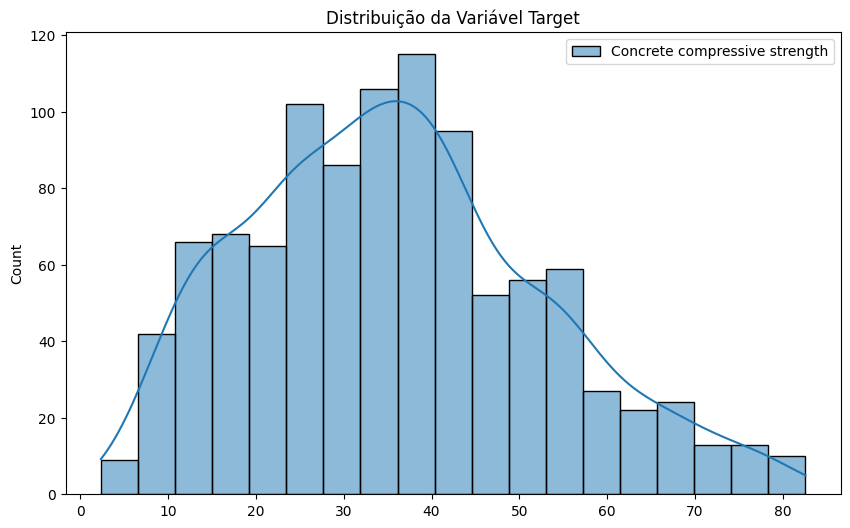

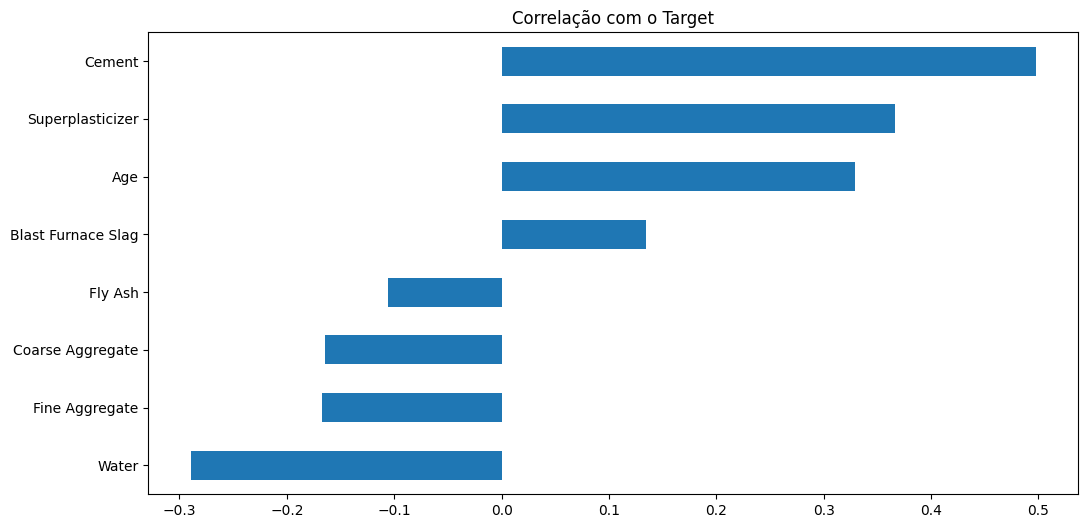

In [7]:
# Verificar distribuição do target
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribuição da Variável Target')
plt.show()

# Correlação entre features numéricas e target
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_features].corrwith(df['Concrete compressive strength'])
plt.figure(figsize=(12, 6))
correlations.sort_values().plot.barh()
plt.title('Correlação com o Target')
plt.show()

---

### 2. Modelagem com Algoritmos Supervisionados:
Utilizamos três modelos com diferentes arquiteturas/configurações, sendo eles:
- **Rede Neural (MLP Regressor):** Com camadas escondidas (hidden layers) variando de 50, 100, 200, 300 e 500;
- **Árvore de Decisão:** Sendo as profundidades máximas 3, 5, 10, 20 e nenhuma;
- **Random Forest:** Sendo o número de árvores 50, 100 e 200 e profundidades máximas como 5, 10, 30 e nenhuma.

Além disso, estaremos extraindo de cada modelo e configuração as features mais **relevantes** e métricas de desempenho, como a MSE, RMSE e R².

In [8]:
# ------------------------- MLP Regressor -------------------------
hidden_layers = [50, 100, 200, 300, 500]  # Número de neurônios nas camadas ocultas
results_mlp = []

# Função para contar o número de parâmetros em um MLP
def count_mlp_params(mlp):
    n_params = 0
    for weights in mlp.coefs_:
        n_params += weights.size
    for bias in mlp.intercepts_:
        n_params += bias.size
    return n_params

for layer in hidden_layers:
    print(f"\n=== Modelo com {layer} camadas ===")
    
    model = MLPRegressor(
        hidden_layer_sizes=(layer,), 
        max_iter=1000,
        solver='adam', 
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Métricas de classificação
    mse = mean_squared_error(y_test, y_pred)
    rmse= np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Complexidade
    n_params = count_mlp_params(model)
    
    results_mlp.append({
        'hidden_layers': layer,
        'n_params': n_params,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Features relevantes
    weights = model.coefs_[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\nTop 5 features mais relevantes:")
    print(importance_df.head())


=== Modelo com 50 camadas ===


c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Top 5 features mais relevantes:
            Feature  Importance
7               Age    0.727957
5  Coarse Aggregate    0.534022
3             Water    0.517618
2           Fly Ash    0.512535
0            Cement    0.509321

=== Modelo com 100 camadas ===


c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Top 5 features mais relevantes:
            Feature  Importance
7               Age    0.587353
2           Fly Ash    0.453185
3             Water    0.401958
0            Cement    0.400279
4  Superplasticizer    0.392519

=== Modelo com 200 camadas ===


c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Top 5 features mais relevantes:
              Feature  Importance
7                 Age    0.367483
2             Fly Ash    0.357938
4    Superplasticizer    0.309495
3               Water    0.302597
1  Blast Furnace Slag    0.299403

=== Modelo com 300 camadas ===


c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Top 5 features mais relevantes:
              Feature  Importance
7                 Age    0.346848
2             Fly Ash    0.291153
1  Blast Furnace Slag    0.260239
3               Water    0.257869
4    Superplasticizer    0.253593

=== Modelo com 500 camadas ===

Top 5 features mais relevantes:
              Feature  Importance
7                 Age    0.268294
2             Fly Ash    0.243467
0              Cement    0.219145
3               Water    0.212008
1  Blast Furnace Slag    0.210618


c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# ------------------------- Decision Tree Regressor -------------------------

max_depth_list = [3, 5, 10, 20, None]
results_dt = []

for max_depth in max_depth_list:
    print(f"\n=== Modelo com profundidade máxima {max_depth} ===")
    DTR = DecisionTreeRegressor(
        max_depth=max_depth,
        criterion='squared_error',
        min_samples_leaf=5, 
        random_state=42
    )
    DTR.fit(X_train, y_train)
    
    # Métricas
    y_pred = DTR.predict(X_test)
    mse = mean_squared_error(y_test, y_pred) # média dos erros quadráticos entre predições e valores reais
    rmse= np.sqrt(mse) # raiz quadrada do erro médio quadrático, menor melhor
    r2 = r2_score(y_test, y_pred) # proporção da variância explicada pelo modelo [0, 1]
    
    # Complexidade
    n_nodes = DTR.tree_.node_count
    depth = DTR.tree_.max_depth
    
    results_dt.append({
        'max_depth_set': max_depth,
        'actual_depth': depth,
        'n_nodes': n_nodes,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
     })

    # Guardando features relevantes
    feature_importance = DTR.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(f"\nFeatures mais relevantes para Decision Tree - Profundidade máxima {max_depth}:")
    print(importance_df.head())



=== Modelo com profundidade máxima 3 ===

Features mais relevantes para Decision Tree - Profundidade máxima 3:
              Feature  Importance
0              Cement    0.477349
7                 Age    0.409372
3               Water    0.074443
4    Superplasticizer    0.038836
1  Blast Furnace Slag    0.000000

=== Modelo com profundidade máxima 5 ===

Features mais relevantes para Decision Tree - Profundidade máxima 5:
              Feature  Importance
0              Cement    0.396135
7                 Age    0.343161
1  Blast Furnace Slag    0.093906
4    Superplasticizer    0.091704
3               Water    0.067874

=== Modelo com profundidade máxima 10 ===

Features mais relevantes para Decision Tree - Profundidade máxima 10:
              Feature  Importance
0              Cement    0.373197
7                 Age    0.332701
1  Blast Furnace Slag    0.096403
4    Superplasticizer    0.083975
3               Water    0.077701

=== Modelo com profundidade máxima 20 ===

Featur

In [10]:
# ------------------------- Random Forest Regressor -------------------------

n_estimators_list = [50, 100, 200]      # Número de árvores
max_depth_list = [5, 10, 30, None]      # Profundidade máxima

results_rf = []

# Verificar e garantir que y_train seja 1D
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.values.ravel()

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        RFR = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            criterion='squared_error', 
            min_samples_leaf=5, 
            n_jobs=1,
            random_state=42
        )
        RFR.fit(X_train, y_train)
        
        # Métricas
        y_pred = RFR.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        # Complexidade
        avg_depth = np.mean([tree.tree_.max_depth for tree in RFR.estimators_])
        n_params = sum(tree.tree_.n_node_samples.size for tree in RFR.estimators_)
        
        results_rf.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'avg_depth': avg_depth,
            'n_params': n_params,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        })

        # Guardando features relevantes
        feature_importance = RFR.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print(f"\nFeatures mais relevantes para Random Forest - Profundidade máxima {max_depth} | Árvores {n_estimators}:")
        print(importance_df.head())

        """
        # Plotagem das predições
        
        plt.scatter(y_test, y_pred)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Valores Reais')
        plt.ylabel('Predições')
        plt.title(f'Predições vs Reais (R² = {r2:.2f}) - n_estimators={n_estimators}, max_depth={max_depth}')
        plt.show()

        """


Features mais relevantes para Random Forest - Profundidade máxima 5 | Árvores 50:
              Feature  Importance
7                 Age    0.379464
0              Cement    0.338010
3               Water    0.114889
4    Superplasticizer    0.063201
1  Blast Furnace Slag    0.059669

Features mais relevantes para Random Forest - Profundidade máxima 10 | Árvores 50:
              Feature  Importance
7                 Age    0.355784
0              Cement    0.324911
3               Water    0.117631
4    Superplasticizer    0.068658
1  Blast Furnace Slag    0.065523

Features mais relevantes para Random Forest - Profundidade máxima 30 | Árvores 50:
              Feature  Importance
7                 Age    0.355602
0              Cement    0.324842
3               Water    0.117605
4    Superplasticizer    0.068658
1  Blast Furnace Slag    0.065292

Features mais relevantes para Random Forest - Profundidade máxima None | Árvores 50:
              Feature  Importance
7                

In [20]:
# Compilado da porcentagem das features mais importantes nos 3 modelos

# Função para extrair top N features de importância de cada modelo
def get_top_features(importance_df, top_n=3):
    return importance_df.sort_values('Importance', ascending=False)['Feature'].head(top_n).tolist()

# MLP: já temos importance_df do último modelo treinado, mas vamos pegar dos 5 modelos
mlp_top_features = []
for res in results_mlp:
    # Para cada configuração, precisamos calcular importance_df novamente
    layer = res['hidden_layers']
    model = MLPRegressor(hidden_layer_sizes=(layer,), max_iter=1000, solver='adam', random_state=42)
    model.fit(X_train, y_train)
    weights = model.coefs_[0]
    feature_importance = np.mean(np.abs(weights), axis=1)
    imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    mlp_top_features.extend(get_top_features(imp_df))

# Decision Tree: já temos importance_df para cada profundidade
dt_top_features = []
for res in results_dt:
    DTR = DecisionTreeRegressor(max_depth=res['max_depth_set'], min_samples_leaf=5, random_state=42)
    DTR.fit(X_train, y_train)
    feature_importance = DTR.feature_importances_
    imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    dt_top_features.extend(get_top_features(imp_df))

# Random Forest: para cada configuração
rf_top_features = []
for res in results_rf:
    RFR = RandomForestRegressor(
        n_estimators=res['n_estimators'],
        max_depth=res['max_depth'],
        min_samples_leaf=5,
        n_jobs=1,
        random_state=42
    )
    RFR.fit(X_train, y_train)
    feature_importance = RFR.feature_importances_
    imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    rf_top_features.extend(get_top_features(imp_df))

# Compilar todas as features
all_top_features = mlp_top_features + dt_top_features + rf_top_features

# Calcular porcentagem de aparição de cada feature
feature_counts = pd.Series(all_top_features).value_counts(normalize=True) * 100

# Exibir resultado
print("Porcentagem de aparição das features mais importantes nos 3 modelos:")
print(feature_counts.round(2).to_string())

c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

Porcentagem de aparição das features mais importantes nos 3 modelos:
Age                   33.33
Cement                27.27
Water                 22.73
Blast Furnace Slag     7.58
Fly Ash                6.06
Coarse Aggregate       1.52
Superplasticizer       1.52


---

### 3. Critérios de Avaliação:
**Erro de predição**: utilizar métricas como MSE, RMSE, acurácia, F1-score, conforme o tipo de problema.

**Complexidade do modelo**:
* **Redes neurais**: número de parâmetros treináveis.
* **Árvores de decisão**: profundidade ou número de nós.
* **Random Forest**: número de árvores e profundidade média.

In [12]:
# ------------------------- Visualização das métricas -------------------------
print("\nResultados da MLP:")
df_results_mlp = pd.DataFrame(results_mlp)
print(df_results_mlp.sort_values('R2', ascending=False))


Resultados da MLP:
   hidden_layers  n_params        MSE      RMSE        R2
4            500      5001  25.994641  5.098494  0.903928
3            300      3001  27.775195  5.270218  0.897347
2            200      2001  29.843404  5.462912  0.889703
1            100      1001  33.714851  5.806449  0.875395
0             50       501  47.349047  6.881064  0.825005


In [14]:
print("\nResultados do Decision Tree:")
df_results_dt = pd.DataFrame(results_dt)
print(df_results_dt.sort_values('R2', ascending=False))


Resultados do Decision Tree:
   max_depth_set  actual_depth  n_nodes         MSE       RMSE        R2
3           20.0            12      225   45.603971   6.753071  0.831455
4            NaN            12      225   45.603971   6.753071  0.831455
2           10.0            10      209   46.111220   6.790524  0.829580
1            5.0             5       59   81.415747   9.023068  0.699100
0            3.0             3       15  120.612329  10.982364  0.554236


In [15]:
print("\nResultados do Random Forest:")
df_results_rf = pd.DataFrame(results_rf)
print(df_results_rf.sort_values('R2', ascending=False))


Resultados do Random Forest:
    n_estimators  max_depth  avg_depth  n_params        MSE      RMSE  \
6            100       30.0     10.500     14344  37.362374  6.112477   
7            100        NaN     10.500     14344  37.362374  6.112477   
5            100       10.0      9.850     14128  37.485542  6.122544   
2             50       30.0     10.440      7172  37.630930  6.134405   
3             50        NaN     10.440      7172  37.630930  6.134405   
1             50       10.0      9.860      7076  37.697593  6.139837   
10           200       30.0     10.485     28750  37.813874  6.149299   
11           200        NaN     10.485     28750  37.813874  6.149299   
9            200       10.0      9.855     28336  37.888791  6.155387   
4            100        5.0      5.000      5442  53.420905  7.308961   
0             50        5.0      5.000      2712  53.795914  7.334570   
8            200        5.0      5.000     10896  54.607772  7.389707   

          R2  
6   0

In [21]:
# Relação das features mais utilizadas com os resultados obtidos em cada modelo

def summarize_feature_results(top_features, results, model_name, feature_list=None):
    summary = []
    if feature_list is None:
        feature_list = X.columns.tolist()
    for i, res in enumerate(results):
        # Extrai as top features para cada configuração
        if model_name == 'MLP':
            layer = res['hidden_layers']
            model = MLPRegressor(hidden_layer_sizes=(layer,), max_iter=1000, solver='adam', random_state=42)
            model.fit(X_train, y_train)
            weights = model.coefs_[0]
            feature_importance = np.mean(np.abs(weights), axis=1)
            imp_df = pd.DataFrame({'Feature': feature_list, 'Importance': feature_importance})
            top_feats = imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()
        elif model_name == 'DT':
            DTR = DecisionTreeRegressor(max_depth=res['max_depth_set'], min_samples_leaf=5, random_state=42)
            DTR.fit(X_train, y_train)
            feature_importance = DTR.feature_importances_
            imp_df = pd.DataFrame({'Feature': feature_list, 'Importance': feature_importance})
            top_feats = imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()
        elif model_name == 'RF':
            RFR = RandomForestRegressor(
                n_estimators=res['n_estimators'],
                max_depth=res['max_depth'],
                min_samples_leaf=5,
                n_jobs=1,
                random_state=42
            )
            RFR.fit(X_train, y_train)
            feature_importance = RFR.feature_importances_
            imp_df = pd.DataFrame({'Feature': feature_list, 'Importance': feature_importance})
            top_feats = imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()
        else:
            top_feats = []

        summary.append({
            'Modelo': model_name,
            'Configuração': res,
            'Top Features': top_feats,
            'R2': res['R2'],
            'MSE': res['MSE'],
            'RMSE': res['RMSE'] if 'RMSE' in res else None
        })
    return summary

mlp_summary = summarize_feature_results(mlp_top_features, results_mlp, 'MLP')
dt_summary = summarize_feature_results(dt_top_features, results_dt, 'DT')
rf_summary = summarize_feature_results(rf_top_features, results_rf, 'RF')

# Exibir resumo
for model_summary in [mlp_summary, dt_summary, rf_summary]:
    print(f"\n{'='*20} {model_summary[0]['Modelo']} {'='*20}")
    for entry in model_summary:
        print(f"Configuração: {entry['Configuração']}")
        print(f"Top Features: {entry['Top Features']}")
        print(f"R2: {entry['R2']:.3f} | MSE: {entry['MSE']:.2f} | RMSE: {entry['RMSE']:.2f}")
        print('-'*40)

c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 


==================== MLP ====================
Configuração: {'hidden_layers': 50, 'n_params': 501, 'MSE': 47.34904666802532, 'RMSE': 6.88106435575379, 'R2': 0.8250053587410389}
Top Features: ['Age', 'Coarse Aggregate', 'Water']
R2: 0.825 | MSE: 47.35 | RMSE: 6.88
----------------------------------------
Configuração: {'hidden_layers': 100, 'n_params': 1001, 'MSE': 33.71485070067519, 'RMSE': 5.806449061231416, 'R2': 0.8753952060570569}
Top Features: ['Age', 'Fly Ash', 'Water']
R2: 0.875 | MSE: 33.71 | RMSE: 5.81
----------------------------------------
Configuração: {'hidden_layers': 200, 'n_params': 2001, 'MSE': 29.843404190635976, 'RMSE': 5.462911695299127, 'R2': 0.8897034644244861}
Top Features: ['Age', 'Fly Ash', 'Superplasticizer']
R2: 0.890 | MSE: 29.84 | RMSE: 5.46
----------------------------------------
Configuração: {'hidden_layers': 300, 'n_params': 3001, 'MSE': 27.775195368696327, 'RMSE': 5.270217772416651, 'R2': 0.8973472394593139}
Top Features: ['Age', 'Fly Ash', 'Blast F

In [22]:
# Selecionar as top features do modelo com maior R² de cada tipo

# MLP
best_mlp_idx = df_results_mlp['R2'].idxmax()
best_mlp_layer = results_mlp[best_mlp_idx]['hidden_layers']
best_mlp_model = MLPRegressor(hidden_layer_sizes=(best_mlp_layer,), max_iter=1000, solver='adam', random_state=42)
best_mlp_model.fit(X_train, y_train)
mlp_weights = best_mlp_model.coefs_[0]
mlp_feature_importance = np.mean(np.abs(mlp_weights), axis=1)
mlp_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': mlp_feature_importance})
mlp_top3 = mlp_imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()

# Decision Tree
best_dt_idx = df_results_dt['R2'].idxmax()
best_dt_depth = results_dt[best_dt_idx]['max_depth_set']
best_dt_model = DecisionTreeRegressor(max_depth=best_dt_depth, min_samples_leaf=5, random_state=42)
best_dt_model.fit(X_train, y_train)
dt_feature_importance = best_dt_model.feature_importances_
dt_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': dt_feature_importance})
dt_top3 = dt_imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()

# Random Forest
best_rf_idx = df_results_rf['R2'].idxmax()
best_rf_conf = results_rf[best_rf_idx]
best_rf_model = RandomForestRegressor(
    n_estimators=best_rf_conf['n_estimators'],
    max_depth=best_rf_conf['max_depth'],
    min_samples_leaf=5,
    n_jobs=1,
    random_state=42
)
best_rf_model.fit(X_train, y_train)
rf_feature_importance = best_rf_model.feature_importances_
rf_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importance})
rf_top3 = rf_imp_df.sort_values('Importance', ascending=False)['Feature'].head(3).tolist()

print("Top 3 features do melhor MLP:", mlp_top3)
print("Top 3 features da melhor Decision Tree:", dt_top3)
print("Top 3 features do melhor Random Forest:", rf_top3)

c:\Users\amand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Top 3 features do melhor MLP: ['Age', 'Fly Ash', 'Cement']
Top 3 features da melhor Decision Tree: ['Cement', 'Age', 'Blast Furnace Slag']
Top 3 features do melhor Random Forest: ['Age', 'Cement', 'Water']


---

### 4. Otimização Multiobjetivo:
Utilizar alguma abordagem para encontrar modelos que equilibrem desempenho e complexidade, como:
- Busca em grade ou aleatória com análise biobjetiva.
- Algoritmos evolutivos (como NSGA-II, se desejado).
- Análise e visualização da fronteira de Pareto.

In [19]:
# ------------------------- Análise Multiobjetivo -------------------------

# Adicionar coluna de modelo para cada DataFrame

df_results_mlp['model'] = 'MLP Regressor'
df_results_rf['model'] = 'Random Forest'
df_results_dt['model'] = 'Decision Tree'

# Selecionando apenas colunas relevantes
df_results_dt = df_results_dt[['n_nodes', 'R2']]
df_results_dt['n_params'] = df_results_dt['n_nodes']
df_results_rf = df_results_rf[['n_params', 'R2']]

df_results_mlp = df_results_mlp[['n_params', 'R2']]

# Unificando resultados em um dataframe
df_all = pd.concat([
    df_results_mlp.assign(model='MLP Regressor'),
    df_results_rf.assign(model='Random Forest'),
    df_results_dt.assign(model='Decision Tree')
], ignore_index=True)
 

In [40]:
def is_pareto_efficient(df):
    data = df[['n_params', 'R2']].copy()
    # Muda R² para -R² para poder usar algoritmo de minimização
    data['R2'] = -data['R2']
    # Convertendo para numpy array
    costs = data.to_numpy()
    
    # Inicializa um array booleano para identificar soluções eficientes
    is_efficient = np.ones(costs.shape[0], dtype=bool)

    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Verifica se há outras soluções que são melhores ou iguais em todos os objetivos
            # descarta soluções que são dominadas
            is_efficient[is_efficient] = (
                np.any(costs[is_efficient] < c, axis=1) | 
                np.all(costs[is_efficient] == c, axis=1)
            )
            is_efficient[i] = True # garante que a solução atual é considerada eficiente
    return is_efficient


df_all['pareto'] = is_pareto_efficient(df_all)
pareto_df = df_all[df_all['pareto']] # DataFrame com soluções eficientes de Pareto


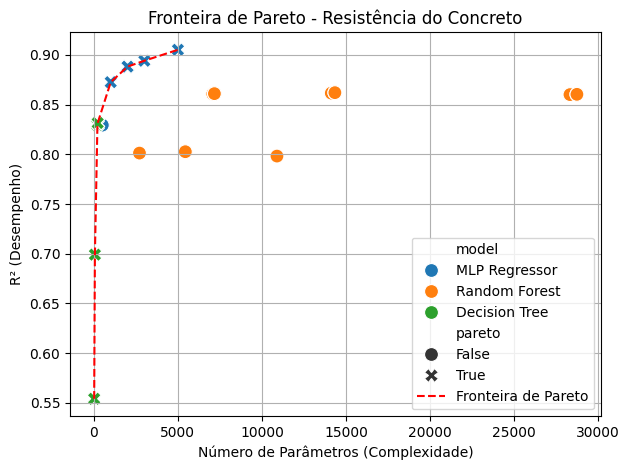

In [42]:
# ------------------------- Visualização da Fronteira de Pareto -------------------------
sns.scatterplot(
    data=df_all, 
    x='n_params', 
    y='R2', 
    hue='model', 
    style='pareto', 
    s=100)

pareto_sorted = pareto_df.sort_values('n_params')

plt.plot(
    pareto_sorted['n_params'], 
    pareto_sorted['R2'], 
    linestyle='--', 
    color='red', 
    label='Fronteira de Pareto')


plt.xlabel('Número de Parâmetros (Complexidade)')
plt.ylabel('R² (Desempenho)')
plt.title('Fronteira de Pareto - Resistência do Concreto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Melhores Modelos
1. **MLP Regressor - 0.90**

A maioria dos modelos foram bem. O aumento do número de camadas ocultas melhora o desempenho (R²), mas aumenta significativamente a complexidade (número de parâmetros), ou seja, o ganho de desempenho diminui conforme o número de camadas cresce, podendo indicar overfitting.
O modelo com 500 neurônios atinge o melhor R², mas pode ser considerado superdimensionado para ganhos marginais.

2. **Random Forest (n_estimators = 100, max_depth = 30) - 0.86** 

O resultado dos modelos foram bem semelhantes. Os melhores foram os que tiveram profundidade de 30 ou sem limite. Porém, apesar do modelo com profundidade de 30 ou sem limite ter tido a métrica R² melhor, o modelo com limite de profundidade = 10 e numero de arvores 50 teve uma métrica bem parecida com numero de parametros bem menor, ou seja, menos complexo.

3.  **Decision Tree (max_depth = 20) - 0.83**

Aumentar a profundidade máxima não melhorou muita coisa, visto que a profundidade máxima alcançada foi 12 e não houve melhoras de desempenho relevante ao aumentar para além de 10. 

## Observações
É importante observar que no inicio as feratures pontuadas como maior correlação com aumento do valor do target seriam Cement, Superplasticizer, Age e Blast furnace slag. Ao verificarmos os melhores resultados podemos observar que as features que tiveram maior relevancia dentre elas são Age e Cement estando presentes em todos os melhores R², confirmando assim a sua relevancia.
